# International Mathematical Olympiad (IMO) Analysis 🧮

This week, for #tidytuesday, we are analyzing data from the International Mathematical Olympiad (IMO).

For data and a better intro than mine, go ➡️ [here](data/2024/2024-09-24/readme.md)

Here is a little bit about the IMO:

> The International Mathematical Olympiad (IMO) is the World Championship Mathematics Competition for High School students and is held annually in a different country. The first IMO was held in 1959 in Romania, with 7 countries participating. It has gradually expanded to over 100 countries from 5 continents. The competition consists of 6 problems and is held over two consecutive days with 3 problems each.

Many thanks to [Havisha Khurana](https://github.com/havishak) for putting the dataset together, and to [Emi Tanaka](https://github.com/emitanaka) for catching the bug in the original script!

In [3]:
## Importing Required Packages
using Pkg
Pkg.add(["CSV", "DataFrames", "HTTP", "Statistics", "StatsPlots", "Plots"])

# Load the necessary packages
using CSV, DataFrames, HTTP, Statistics, StatsPlots, Plots


   Resolving package versions...
  No Changes to `C:\Users\ndfos\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ndfos\.julia\environments\v1.10\Manifest.toml`


## Loading Data from URLs
We'll load the datasets into DataFrames from their respective URLs.

I did find an issue with a recent commit of the data after the issue referenced above.  I found that `total` and `rank` were missing from the [data dictionary](https://github.com/rfordatascience/tidytuesday/data/2024/2024-09-24/readme.md) (these have been removed), check out the issue I submitted [here](https://github.com/rfordatascience/tidytuesday/issues/757#issue-2548792636) to see the solution I offer in R so you can get the country_results_df with the `total` and `rank` columns and answer the research questions as I do.  For this reason, the country file is pulled from my Github, all other manipulations are identical to the source.  Doing this is optional, and you can follow the available path via the #tidytuesday Github files that are available and that is just fine.  Jon Harmon and gang do an amazing job, not throwing shade their way at all.

In [129]:
# URLs for the CSV files

country_url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2024/2024-09-24/country_results_df.csv"
individual_url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2024/2024-09-24/individual_results_df.csv"
timeline_url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2024/2024-09-24/timeline_df.csv"

# Reading the data into DataFrames
country_results_df = CSV.read(HTTP.get(country_url).body, DataFrame)
individual_results_df = CSV.read(HTTP.get(individual_url).body, DataFrame)
timeline_df = CSV.read(HTTP.get(timeline_url).body, DataFrame);

## Data Overview and Initial Exploration

### Country Results Data
First, let's take a look at the structure and a sample of the `country_results_df`.

In [130]:
# Display the first few rows and structure of country_results_df
first(country_results_df, 5)  # first 5 rows

Row,year,country,team_size_all,team_size_male,team_size_female,p1,p2,p3,p4,p5,p6,p7,awards_gold,awards_silver,awards_bronze,awards_honorable_mentions,leader,deputy_leader
,Int64,String,Int64,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String?,String?
1,2024,United States of America,6,5,1,42,41,19,40,35,15,NA,5,1,0,0,John Berman,Carl Schildkraut
2,2024,People's Republic of China,6,6,0,42,42,31,40,22,13,NA,5,1,0,0,Liang Xiao,Yijun Yao
3,2024,Republic of Korea,6,6,0,42,37,18,42,7,22,NA,2,4,0,0,Suyoung Choi,Hwajong Yoo
4,2024,India,6,6,0,42,34,11,42,28,10,NA,4,1,0,1,Krishnan Sivasubramanian,Rijul Saini
5,2024,Belarus,6,6,0,42,30,10,42,36,5,NA,4,0,2,0,David Zmiaikou,Dzmitry Bazyleu


In [7]:
# summary statistics
describe(country_results_df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,year,2003.91,1959,2006.0,2024,0,Int64
2,country,,Albania,,Zimbabwe,0,String
3,team_size_all,5.74233,1,6.0,8,0,Int64
4,team_size_male,,0,,NA,0,String3
5,team_size_female,,0,,NA,0,String3
6,p1,,0,,NA,0,String3
7,p2,,0,,NA,0,String3
8,p3,,0,,NA,0,String3
9,p4,,0,,NA,0,String3


## The score columns are strings...

...which could be helpful, potentially not depending on how we conduct our analyses later.

### The `leader` and `deputy_leader` columns have missing values.  Let's explore that.

Black cells are complete, gray cells are missing.

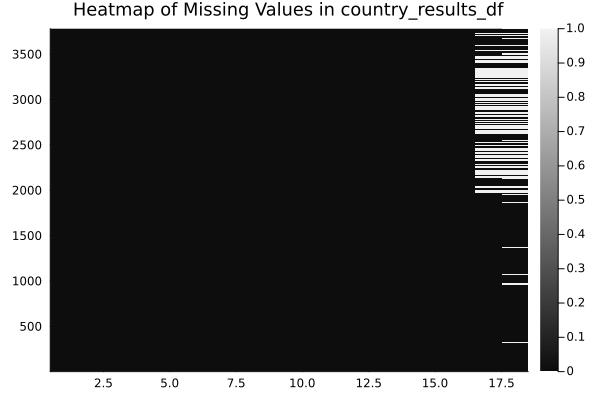

In [28]:
heatmap(
    Matrix(ismissing.(country_results_df)
    ),
    color = :grays,
    title = "Heatmap of Missing Values in country_results_df",
    titlefontsize = 12
)

## The missingness seems to have some structure 
This is problematic, and there seem to be some cases where values in both columns are missing together.  We will need to keep the missingness in mind later when we do further descriptive analyses.  In earlier years, it appears that fewer values were missing, and the missingness could have been missing at random (MAR).  Presently, there seems to be some structure in more recent years in the missingness, which may lead us to conclude that the data are missing not at random (MNAR).

### Let's view a subset of rows from these columns that have missing values

In [35]:
# leader column

first(
    country_results_df[ismissing.(country_results_df.leader), :], 
    5 # number of rows to view
)

Row,year,country,team_size_all,team_size_male,team_size_female,p1,p2,p3,p4,p5,p6,p7,awards_gold,awards_silver,awards_bronze,awards_honorable_mentions,leader,deputy_leader
,Int64,String,Int64,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String?,String?
1,2024,Bolivia,4,3,1,15,2,0,8,0,1,NA,0,0,1,1,missing,Guillermo Fernando Vera Hurtado
2,2024,El Salvador,3,2,1,7,0,0,9,1,0,NA,0,0,0,1,missing,Riquelmi Salvador Cardona Fuentes
3,2024,Nicaragua,1,1,0,7,1,0,7,1,0,NA,0,0,1,0,missing,Rufo Holvin Casco Arévalo
4,2023,Cuba,2,1,1,9,0,0,0,2,0,NA,0,0,0,1,missing,Evidio Quintana Fernández
5,2022,Uruguay,2,2,0,13,2,0,10,2,0,NA,0,0,0,2,missing,Hernán Puschiasis


In [21]:
# deputy leader column
first(
    country_results_df[ismissing.(country_results_df.deputy_leader), :], 
    5 # number of rows to view
)

Row,year,country,team_size_all,team_size_male,team_size_female,p1,p2,p3,p4,p5,p6,p7,awards_gold,awards_silver,awards_bronze,awards_honorable_mentions,leader,deputy_leader
,Int64,String,Int64,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String?,String?
1,2024,Panama,1,1,0,3,0,0,7,0,0,NA,0,0,0,1,Joselito Wong,missing
2,2024,Honduras,1,1,0,1,0,0,0,0,0,NA,0,0,0,0,Devis Moises Alvarado Zavala,missing
3,2023,Peru,6,6,0,37,34,6,36,15,5,NA,0,2,3,0,Jonathan Farfan,missing
4,2023,Uruguay,3,3,0,21,3,1,10,2,0,NA,0,0,0,3,Hernán Puschiasis,missing
5,2023,Nicaragua,3,3,0,12,7,0,3,0,0,NA,0,0,0,2,Oscar Danilo Quintanilla Luna,missing


## More strings in the scores!

We can deal with that later, if needed.

### Missing leaders and deputy leaders?

There are cases where there is no team leader but there is a deputy leader, and there are also cases where there is a leader and no deputy leader.  This seems to make sense given that a competitor could get sick, injured, etc.  Shouldn't that person still be listed, though?

These problems could lead us to need to further look at contextual information about the data to understand this, and this could affect our inferences about future statistical analyses.

## Individual Results Data

In [17]:
# Display the first few rows and structure of individual_results_df
first(individual_results_df, 5)

Row,year,contestant,country,p1,p2,p3,p4,p5,p6,p7,total,individual_rank,award
,Int64,String,String,String3,String3,String3,String3,String3,String3,String3,Int64,String3,String31?
1,2024,Haojia Shi,People's Republic of China,7,7,7,7,7,7,NA,42,1,Gold medal
2,2024,Ivan Chasovskikh,C21,7,7,6,6,7,7,NA,40,2,Gold medal
3,2024,Alexander Wang,United States of America,7,7,3,7,7,7,NA,38,3,Gold medal
4,2024,Satoshi Kano,Japan,7,7,2,7,7,7,NA,37,4,Gold medal
5,2024,László Bence Simon,Hungary,7,7,7,7,7,0,NA,35,5,Gold medal


In [12]:
# summary statistics
describe(individual_results_df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,year,2003.01,1959,2006.0,2024,0,Int64
2,contestant,,*,,Žiga Oštir,0,String
3,country,,Albania,,Zimbabwe,0,String
4,p1,,0,,NA,0,String3
5,p2,,0,,NA,0,String3
6,p3,,0,,NA,0,String3
7,p4,,0,,NA,0,String3
8,p5,,0,,NA,0,String3
9,p6,,0,,NA,0,String3


## Again, scores as strings...

...soon we will check and see if that is helpful or not.

### Let's see a subset of rows where the `award` is missing.

In [44]:
# view some missing rows from award

first(
    individual_results_df[ismissing.(individual_results_df.award), :],
    5
)

Row,year,contestant,country,p1,p2,p3,p4,p5,p6,p7,total,individual_rank,award
,Int64,String,String,String3,String3,String3,String3,String3,String3,String3,Int64,String3,String31?
1,2024,Juan José Martínez Barreto,Venezuela,5,0,0,4,4,0,NA,13,400,missing
2,2024,Matic Pogorelec,Slovenia,6,0,0,6,0,0,NA,12,413,missing
3,2024,Youkyum Kim,South Africa,4,2,0,5,1,0,NA,12,413,missing
4,2024,Jonas Boeykens,Belgium,6,1,0,0,3,0,NA,10,434,missing
5,2024,Hashir Naimat,Pakistan,6,0,0,4,0,0,NA,10,434,missing


### Missing values within the `award` column seem to be related to people that just didn't get a medal.

This makes sense and would be expected.  Let's view the missingness in this dataset via a heatmap below.

Let black cells equal complete values, and those that are gray represent missing values.

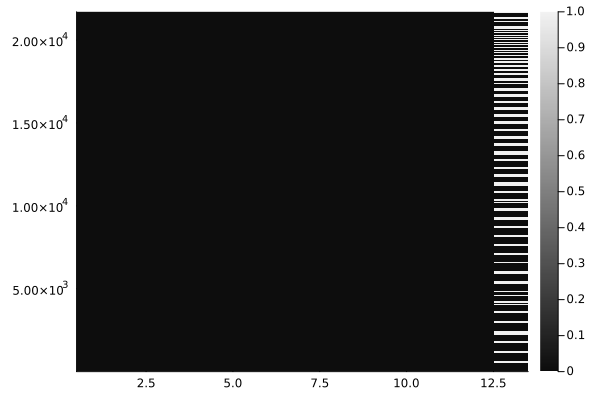

In [24]:
# award column 

heatmap(
    Matrix(
        ismissing.(individual_results_df)
        ), 
        color=:grays
)

### Missingness gets more prevalent over time

The rows at the bottom of the dataframe are older records, and the records at the top are newer based on what we saw earlier.
This shows us that for some reason, these data were complete more often in the past than they are now, and the missingness seems to be systematic with some form of seasonality or (more likely) a cyclical trend.

## Timeline Data

In [13]:
# Display the first few rows and structure of timeline_df
first(timeline_df, 5)

Row,edition,year,country,city,countries,all_contestant,male_contestant,female_contestant,start_date,end_date
,Int64,Int64,String,String,Int64,Int64,Int64,String3,Date,Date
1,65,2024,United Kingdom,Bath,108,609,528,81,2024-07-11,2024-07-22
2,64,2023,Japan,Chiba,112,618,550,67,2023-07-02,2023-07-13
3,63,2022,Norway,Oslo,104,589,521,68,2022-07-06,2022-07-16
4,62,2021,Russian Federation,A distributed IMO administered from St Petersburg,107,619,555,64,2021-07-14,2021-07-24
5,61,2020,Russian Federation,A distributed IMO administered from St Petersburg,105,616,560,56,2020-09-19,2020-09-28


In [14]:
# summary statistics
describe(timeline_df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Any,Any,Int64,DataType
1,edition,33.0,1,33.0,65,0,Int64
2,year,1991.68,1959,1992.0,2024,0,Int64
3,country,,Argentina,,Yugoslavia,0,String
4,city,,A distributed IMO administered from St Petersburg,,Žilina,0,String
5,countries,58.0154,5,56.0,112,0,Int64
6,all_contestant,333.692,39,322.0,621,0,Int64
7,male_contestant,279.877,32,277.0,560,0,Int64
8,female_contestant,,1,,NA,0,String3
9,start_date,,1959-07-21,1992-07-10,2024-07-11,0,Date


### Interesting, no missingness!

This dataset is complete, which is helpful, and the format of the values makes sense so far.

## Analysis Goals
We'll explore the following:

* Shifts in country rankings over time: How do country rankings evolve?
* Gender distribution: What are the gender participation trends?
* Distribution of top scores: Who scores the highest?
* Relationship between team size and country performance: Does a larger team mean better results?
* Relationship between team composition and country performance: Do first-time participants or veterans impact results differently?

## Next Steps
### Data Cleaning and Wrangling

We’ll clean the data, handle missing values, and set up relevant subsets for each goal. Let’s start by handling missing values in each dataset:

#### Dropping or Filling Missing Data
After identifying missing values, decide whether to drop rows with missing data or fill them with an appropriate value (e.g., zeros, mean).

It is clear that we will need to impute some missing values or change the format of some missing values.  Let's create a function to help.

In [57]:
# let's see if any of the individual ranks are "NA"
sum(individual_results_df.individual_rank .== "NA")

29

In [100]:
# Define the function with type checking and error handling
function imo_impute(df::DataFrame, col::Symbol;
    not_value="NA", 
    impute_with=missing, 
    format=Int)
# Replace `not_value` with `impute_with` in the specified column
df[!, col]=replace(df[!, col], not_value => impute_with)

# parse the format of the new column
df[!, col] = passmissing(parse).(format, df[!, col])

return df  # Return the modified DataFrame

end

imo_impute (generic function with 1 method)

### Visualizing Country Rankings Over Time

We will create a line plot showing how the rank of each country has changed over the years.

In [128]:
# individual_rank is a string, which we need to transform
# this function will impute "NA" values with missing, and format the column as Int

country_results_df = imo_impute(country_results_df, :rank)

ArgumentError: ArgumentError: column name :rank not found in the data frame

In [111]:
# How many countries are there?
println("There are ", 
length(unique(country_results_df.country)),
" unique countries in the country_results_df dataset."
)

There are 139 unique countries in the country_results_df dataset


In [127]:
# filter the dataframe to get only top rated countries, given that the levels of that factor or many

individual_results_filtered = filter(row -> !ismissing(row.rank) && row.individual_rank <= 5, individual_results_df)

Row,year,contestant,country,p1,p2,p3,p4,p5,p6,p7,total,individual_rank,award
,Int64,String,String,String3,String3,String3,String3,String3,String3,String3,Int64,Int64?,String31?
1,2024,Haojia Shi,People's Republic of China,7,7,7,7,7,7,NA,42,1,Gold medal
2,2024,Ivan Chasovskikh,C21,7,7,6,6,7,7,NA,40,2,Gold medal
3,2024,Alexander Wang,United States of America,7,7,3,7,7,7,NA,38,3,Gold medal
4,2024,Satoshi Kano,Japan,7,7,2,7,7,7,NA,37,4,Gold medal
5,2024,László Bence Simon,Hungary,7,7,7,7,7,0,NA,35,5,Gold medal
6,2024,Adhitya Mangudy Venkata Ganesh,India,7,7,4,7,7,3,NA,35,5,Gold medal
7,2024,Qiming Xu,People's Republic of China,7,7,7,7,7,0,NA,35,5,Gold medal
8,2024,Hyeongjoe Chu,Republic of Korea,7,2,7,7,7,5,NA,35,5,Gold medal
9,2024,Alex Chui,United Kingdom,7,7,2,7,7,5,NA,35,5,Gold medal
